In [1]:
# 实战回归
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cpu
cpu


In [3]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(data_home='data')#这里用的是sklearn自带的数据集，可以直接用，不需要自己下载
print(housing.DESCR)#查看数据集的描述信息
print(housing.data.shape)#查看数据集的维度
print(housing.target.shape)#查看数据集的维度

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [4]:
import pprint  #打印的格式比较 好看

pprint.pprint(housing.data[0:2])#查看数据集的前两行
pprint.pprint(housing.target[0:2])#查看数据集的前两行的标签

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02]])
array([4.526, 3.585])


In [5]:
from sklearn.model_selection import train_test_split

#拆分训练集和测试集，random_state是随机种子,同样的随机数种子，是为了得到同样的随机值
x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)#拆分训练集和测试集,为了防止过拟合
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)#拆分训练集和验证集,为了防止过拟合

# 打印数据集的大小
# 训练集
print(x_train.shape, y_train.shape)
# 验证集
print(x_valid.shape, y_valid.shape)
# 测试集
print(x_test.shape, y_test.shape)

dataset_maps = {
    "train": [x_train, y_train], #训练集
    "valid": [x_valid, y_valid], #验证集
    "test": [x_test, y_test], #测试集
} #把3个数据集都放到字典中

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [6]:
type(x_train)#查看数据类型,可以发现是numpy数组

numpy.ndarray

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #标准化,标准化是为了让数据分布在一个固定的范围内，比如0到1之间
scaler.fit(x_train)#拟合训练集,拟合是为了得到标准化所需要的参数

StandardScaler()

In [8]:
np.array(1).shape#查看数组的维度

()

In [9]:
from torch.utils.data import Dataset

class HousingDataset(Dataset):
    def __init__(self, mode='train'):
        self.x, self.y = dataset_maps[mode] #从字典中取出数据集
        self.x = torch.from_numpy(scaler.transform(self.x)).float() #from_numpy将NumPy数组转换成PyTorch张量
        self.y = torch.from_numpy(self.y).float().reshape(-1, 1) #处理为多行1列的tensor类型,因为__getitem__切片时需要
            
    def __len__(self): #必须写
        return len(self.x) #返回数据集的长度,0维的size
    
    def __getitem__(self, idx): #idx是索引，返回的是数据和标签，这里是一个样本
        return self.x[idx], self.y[idx]
    
#train_ds是dataset类型的数据，与前面例子的FashionMNIST类型一致
train_ds = HousingDataset("train")#训练集
valid_ds = HousingDataset("valid")#验证集
test_ds = HousingDataset("test")#测试集

In [10]:
type(train_ds)#查看数据类型,可以发现是HousingDataset类型

__main__.HousingDataset

In [11]:
train_ds[1] #查看训练集的第2个样本

(tensor([-0.2981,  0.3523, -0.1092, -0.2506, -0.0341, -0.0060,  1.0806, -1.0611]),
 tensor([1.5140]))

In [12]:
train_ds[0][0] #查看训练集的第1个样本的特征,可以发现是tensor类型

tensor([ 0.8015,  0.2722, -0.1162, -0.2023, -0.5431, -0.0210, -0.5898, -0.0824])

In [13]:
from torch.utils.data import DataLoader

batch_size = 16 #batch_size是可以调的超参数
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)#训练集的DataLoader,shuffle=True表示打乱数据
val_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)#验证集的DataLoader,shuffle=False表示不打乱数据
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)#测试集的DataLoader,shuffle=False表示不打乱数据

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=8):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
            )#定义网络结构,这里的30是隐藏层的神经元个数，可以根据实际情况调整,这里的1是输出层的神经元个数，因为是回归问题，所以只有一个神经元
        
    def forward(self, x):
        # x.shape [batch size, 8]
        logits = self.linear_relu_stack(x)#前向传播,这里的logits是未经激活函数的输出,也就是线性层的输出,这里的x是输入数据,也就是特征
        # logits.shape [batch size, 1]
        return logits#返回输出值,也就是预测值

In [15]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience

In [16]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)#将数据放到GPU上,因为数据在DataLoader中是放在CPU上的
        labels = labels.to(device)#将标签放到GPU上,因为数据在DataLoader中是放在CPU上的
        # 前向计算
        logits = model(datas)#前向传播,这里的logits是未经激活函数的输出,也就是线性层的输出,这里的x是输入数据,也就是特征
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())#将损失值添加到列表中,这里的loss是经过激活函数的输出,也就是最终的预测结果
        
    return np.mean(loss_list)#返回损失值的平均值

In [26]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:#11610/16=726
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas) #得到预测值
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
 
                loss = loss.cpu().item() #转为cpu类型，item()是取值
                # record
                
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()

                    # 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss) #根据验证集的损失来实现早停
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 100

model = NeuralNetwork()#定义模型

# 1. 定义损失函数 采用MSE损失,均方误差
loss_fct = nn.MSELoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10, min_delta=1e-3)

model = model.to(device)
record = training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )#训练模型

  0%|          | 0/72600 [00:00<?, ?it/s]

Early stop at epoch 78 / global_step 56628


In [27]:
record

{'train': [{'loss': 7.369191646575928, 'step': 0},
  {'loss': 4.89227294921875, 'step': 1},
  {'loss': 4.918410778045654, 'step': 2},
  {'loss': 5.223506927490234, 'step': 3},
  {'loss': 6.209366798400879, 'step': 4},
  {'loss': 4.520529747009277, 'step': 5},
  {'loss': 2.917858362197876, 'step': 6},
  {'loss': 3.3946497440338135, 'step': 7},
  {'loss': 2.5085506439208984, 'step': 8},
  {'loss': 4.755073547363281, 'step': 9},
  {'loss': 2.025489568710327, 'step': 10},
  {'loss': 2.070866584777832, 'step': 11},
  {'loss': 1.6017040014266968, 'step': 12},
  {'loss': 1.6255062818527222, 'step': 13},
  {'loss': 2.5181126594543457, 'step': 14},
  {'loss': 2.511561155319214, 'step': 15},
  {'loss': 2.303145408630371, 'step': 16},
  {'loss': 2.4922139644622803, 'step': 17},
  {'loss': 1.6181279420852661, 'step': 18},
  {'loss': 1.424964427947998, 'step': 19},
  {'loss': 1.2844531536102295, 'step': 20},
  {'loss': 1.7901794910430908, 'step': 21},
  {'loss': 2.765756130218506, 'step': 22},
  {'

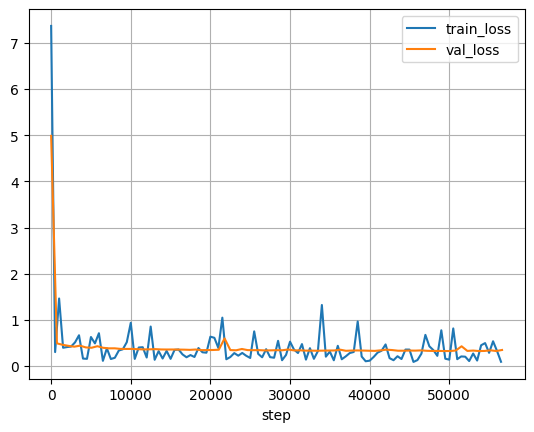

In [28]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]#每隔500个step取一个点，这样可以减少画图的数量,这样可以减少画图的时间
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")#

    # plot
    for idx, item in enumerate(train_df.columns):
        plt.plot(train_df.index, train_df[item], label=f"train_{item}")#画训练集的损失曲线
        plt.plot(val_df.index, val_df[item], label=f"val_{item}")
        plt.grid()
        plt.legend()
        plt.xlabel("step")
        plt.show()

plot_learning_curves(record)  # 画图,这里的record是训练过程中记录的损失值和step数

In [29]:
model.eval()#将模型设置为评估模式
loss = evaluating(model, test_loader, loss_fct)#计算测试集的损失值,这里的loss是经过激活函数的输出,也就是最终的预测结果
print(f"loss:     {loss:.4f}")#打印测试集的损失值

loss:     0.3355
